In [89]:
import copy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Read in input files

In [64]:
#Ecoli information
ecoli_df = pd.read_csv('../Data/ecoli_info/temp_ecoli_master_table.tsv', sep='\t')

In [65]:
ecoli_df

,locus_tag,gene,start_loc,stop_loc,strand,cds_seq,us_seq,well_behaved,iCUB,roc_semppr_mean,CAI,tAI,stAIcalc
0,b0001,thrL,189,255,+,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,CAGATAAAAATTACAGAGTACACAACATCC,True,32.046035,1.244106,0.617266,0.262286,0.258417
1,b0002,thrA,336,2799,+,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,TTTTCGACCAAAGGTAACGAGGTAACAACC,True,55.949262,1.034078,0.353246,0.230564,0.216862
2,b0003,thrB,2800,3733,+,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,GTACCCTCTCATGGAAGTTAGGAGTCTGAC,True,56.062386,0.994168,0.357812,0.216292,0.210420
3,b0004,thrC,3733,5020,+,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,ACGGCGGGCGCACGAGTACTGGAAAACTAA,True,53.052776,1.176750,0.394675,0.231407,0.209784
4,b0005,yaaX,5233,5530,+,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,CATAACGGGCAATGATAAAAGGAGTAACCT,True,50.705530,0.837528,0.374371,0.197715,0.208944
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4350,b4399,creC,4636695,4638120,+,ATGCGTATCGGCATGCGGTTGTTGCTGGGCTATTTTTTACTGGTGG...,CGGCATGGGATATAGCCTGAGGGGCCTGTA,True,55.967103,0.829794,0.293537,0.212672,0.206721
4351,b4400,creD,4638177,4639530,+,ATGTTGAAATCCCCCCTGTTCTGGAAAATGACTAGCCTGTTTGGTG...,TATCCTGCTGCCATTGCAAAGGAGAAGACT,True,54.634345,0.739848,0.288635,0.210078,0.199677
4352,b4401,arcA,4639589,4640306,-,ATGCAGACCCCGCACATTCTTATCGTTGAAGACGAGTTGGTAACAC...,TCGATTTAGTTGGCAATTTAGGTAGCAAAC,True,48.981781,1.676448,0.530773,0.275348,0.239921
4353,b4402,yjjY,4640401,4640542,+,ATGACTAAAGTACGTAATTGCGTTCTTGATGCACTTTCCATCAACG...,CATGCTGCAAATTAACATGATCGGCGTAAC,True,47.451431,0.802032,0.314394,0.219204,0.230201


In [66]:
df = pd.ExcelFile(r'../Data/raw_data/41467_2019_13483_MOESM4_ESM.xlsx')

In [67]:
expression_df = df.parse('Expression Data', index_col='log-TPM')
metadata_df = df.parse('Metadata')

# Remove all Sample IDs that are irrelevant

In [68]:
#Remove samples that contain no growth rate information
metadata_df = metadata_df.dropna(subset=['Growth Rate (1/hr)'])
metadata_df = metadata_df[metadata_df['Growth Rate (1/hr)'] != 0]

In [69]:
#Remove all Sample IDs where the alignment is less than 80%
metadata_df = metadata_df[metadata_df['Alignment'] > 80]

In [70]:
#Remove all columns where no growth rate information was found
expression_df = expression_df[metadata_df['Sample ID']]
assert list(metadata_df['Sample ID']) == list(expression_df.columns)

***Average across replicates and drop them***

In [71]:
cols = []
unique_cols = []
expression_clean_df = copy.deepcopy(expression_df)

#Rename columns in dataframe
for column in expression_df.columns:
    cols.append(column[:-3])
    #Get names of unique columns
    if column[:-3] not in unique_cols:
        unique_cols.append(column[:-3])

expression_clean_df.columns = cols

#New dataframe with averaged replicates and no duplicates
expression_clean_df = expression_clean_df[unique_cols].groupby(level=0, axis=1).mean()

In [72]:
#Average growth rate in metadata df

cond = []
unique_cond = []
metadata_clean_df = copy.deepcopy(metadata_df)

for condition in metadata_df['Sample ID']:
    cond.append(condition[:-3])
    if condition[:-3] not in unique_cond:
        unique_cond.append(condition[:-3])
        
metadata_clean_df['Sample ID'] = cond

#New dataframe with averaged replicates and no duplicates
metadata_clean_df = metadata_clean_df.groupby('Sample ID').mean()

In [73]:
#Make sure columns are the same in expression data as metadata
print(metadata_clean_df.shape)
print(expression_clean_df.shape)

(105, 6)
(3923, 105)


In [74]:
#Remove genes from ecoli_df if not tagged in expression dataset
ecoli_clean_df = copy.deepcopy(ecoli_df)

for locus in range(len(ecoli_df)):
    if ecoli_df['locus_tag'][locus] not in expression_clean_df.index.tolist():
        ecoli_clean_df = ecoli_clean_df.drop(locus)

expression_final_df = copy.deepcopy(expression_clean_df)

for locus in range(len(expression_clean_df)):
    if expression_clean_df.index[locus] not in ecoli_clean_df['locus_tag'].tolist():
        expression_final_df = expression_final_df.drop(expression_clean_df.index[locus])

In [78]:
print(ecoli_clean_df.shape)
print(expression_final_df.shape)

(3859, 13)
(3859, 105)


# Correlation between codon bias metrics

In [84]:
metric_df = ecoli_clean_df[['iCUB', 'roc_semppr_mean', 'CAI', 'tAI', 'stAIcalc']]
metric_df

,iCUB,roc_semppr_mean,CAI,tAI,stAIcalc
1,55.949262,1.034078,0.353246,0.230564,0.216862
2,56.062386,0.994168,0.357812,0.216292,0.210420
3,53.052776,1.176750,0.394675,0.231407,0.209784
4,50.705530,0.837528,0.374371,0.197715,0.208944
5,53.158862,1.032499,0.353849,0.225856,0.213151
...,...,...,...,...,...
4349,54.346407,0.752851,0.275049,0.212304,0.195169
4350,55.967103,0.829794,0.293537,0.212672,0.206721
4351,54.634345,0.739848,0.288635,0.210078,0.199677
4352,48.981781,1.676448,0.530773,0.275348,0.239921


In [85]:
metric_corr = metric_df.corr(method='spearman')
metric_corr

,iCUB,roc_semppr_mean,CAI,tAI,stAIcalc
iCUB,1.000000,-0.515658,-0.581081,-0.538805,-0.486559
roc_semppr_mean,-0.515658,1.000000,0.939023,0.837262,0.546885
CAI,-0.581081,0.939023,1.000000,0.843535,0.695474
tAI,-0.538805,0.837262,0.843535,1.000000,0.740101
stAIcalc,-0.486559,0.546885,0.695474,0.740101,1.000000


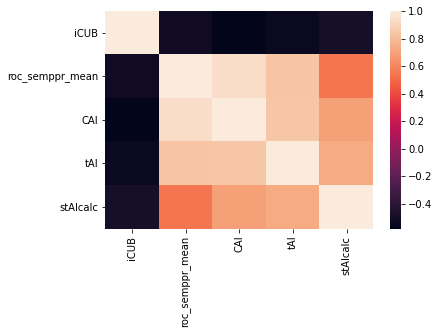

In [91]:
#Visualize correlation matrix
sns.heatmap(metric_corr)
plt.show()